In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

question_df = pd.DataFrame(np.nan, index=range(len(total_url_list)), columns=range(4))
question_df.columns = ["제목", "내용", "작성일", "링크"]
question_df["링크"] = total_url_list
question_df

## 1.2 링크를 통해 제목, 내용, 작성일 수집

In [ ]:
for i in range(len(question_df)):
    try:
        html = urlopen(question_df["링크"][i])
        bs2 = BeautifulSoup(html.read(), "html5lib")


        question_date = bs2.find_all("span", {"class" : "c-userinfo__info"})
        question_text = bs2.find_all("div", {"class" : "c-heading__content"})
        question_title = bs2.find_all("div",{"class" : "title"})

        date = str(question_date)
        date_soup = BeautifulSoup(date, "html.parser")
        # date_element = date_soup.find('span', class_='blind', string='작성일')
        # dirty_date = date_soup.find_parents('span')
        date_pattern = r'(\d{4}.\d{2}.\d{2})'
        match = re.search(date_pattern, str(date_soup))
        if match:
            cleaned_date = match.group(1)

        else:
            pass

        title = str(question_title)
        title_soup = BeautifulSoup(title, 'html.parser')
        title_element = title_soup.find('div', class_='title')
        cleaned_title = title_element.get_text(strip=True)

        text = str(question_text)
        text_soup = BeautifulSoup(text, "html.parser")
        plain_text = text_soup.get_text()
        cleaned_text = ' '.join(plain_text.split())

        question_df["작성일"][i] = cleaned_date
        question_df["제목"][i] = cleaned_title
        question_df["내용"][i] = cleaned_text
    except AttributeError:
        pass

# 2. 전처리

In [ ]:
import pandas as pd
import numpy as np

question_df = pd.read_excel("/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/raw_data2.xlsx")

# 결측 제거
question_df.dropna(axis=0, inplace=True)

# 제목에 질문을 넣은 케이스 처리
for i in question_df.index:
  if question_df["내용"][i] == "[]":
    question_df["내용"][i] = question_df["제목"][i]
    question_df["제목"][i] = "전세사기 피해"

# 작성일 순으로 정렬
question_df.sort_values(by="작성일", ascending=False, inplace=True)

# 2019년 이전 질문 제거
question_df = question_df[question_df["작성일"] >= "2019-01-01"]

# 특수문자 제거
question_df['내용'] = question_df['내용'].str.replace(pat=r'[^\w.]', repl=r' ', regex=True)
question_df["내용"] = question_df["내용"].str.replace("ㅜ", "")
question_df["내용"] = question_df["내용"].str.replace("ㅠ", "")

# 중복질문 제거
question_df.drop_duplicates(["내용"], inplace=True)

In [ ]:
# 띄어쓰기 교정
import keras
import tensorflow
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git --no-deps argument
from pykospacing import Spacing
spacing = Spacing()

# 내용에 특정 키워드만 포함하는 질문만을 추출
jisik_df = question_df[question_df["내용"].str.contains("사기|피해|바지|경매|대처|대책|대응|구제")]

for i in range(len(jisik_df)):
  jisik_df["내용"].iloc[i] = spacing(jisik_df["내용"].iloc[i])

# jisik_df.to_excel("/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/전세사기_피해질문.xlsx", index=False)

In [1]:
import keras
import tensorflow
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git --no-deps argument
from pykospacing import Spacing
spacing = Spacing()

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-eyv1nasy
  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-eyv1nasy
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit 04aeebcbe26b109486a642e57dc58665c4818cf3
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2270663 sha256=51e7e361f1ba6098f957909f6c3c06da1bf42685730cfd87e06a7df6a26cfeac
  Stored in directory: /tmp/pip-ephem-wheel-cache-msqaf3jf/wheels/76/b3/33/dda14886ee76b8e53eb05580a14dfcf9145e9eb9d282c53f28
  Created wheel for argument: filename=argument-1.4.0-py3-none-any.whl size=5663 sha256=58f180c09277ea3b831f25ad7653aa5010ea84e82586146d05813f698e60e179
  Stored in directory: /root/.cache/pip/wheels/96/e4/24/16286476433011a8a2cb42be418e9a2fee32e7b0285bb0ced7
Successfully built pykospacing argument


In [3]:
from pykospacing import Spacing
spacing = Spacing()
spacing("텍스트정보분석은즐겁다")

'텍스트 정보분석은 즐겁다'

## 2.1 형태소 추출
뽑을 것들<br>
**VV(-I, -R)** - 동사 <br>
**VA(-I, -R)** - 형용사 <br>
**NNG** - 일반명사 <br>
**NNP** - 고유명사

In [ ]:
!pip install kiwipiepy
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
import pandas as pd
import numpy as np

kiwi = Kiwi(model_type="sbg")
stopwords = Stopwords()

jisik_df = pd.read_excel("/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/전세사기_피해질문.xlsx")
jisik_df["content word"] = np.nan

# 형태소 분석기 결과의 사용할 태그
use_list_v = ["VV", "VV-I", "VV-R", "VA", "VA-I", "VA-R"] # 동사 및 형용사
use_list_n = ["NNG", "NNP"] # 일반명사, 고유명사

for i in range(len(jisik_df)):
  content_list = []
  tokens = kiwi.tokenize(jisik_df["내용"][i], stopwords=stopwords)
  for j in tokens:
    if j.tag in use_list_v:
      content_list.append(j.form + "다")
    elif (j.tag in use_list_n) and (j.form not in ["문의", "답변", "질문", "부탁"]):
      content_list.append(j.form)
  jisik_df["content word"][i] = content_list

# 제거하지 않을 1음절 명사
one_syllable_list = ["집", "돈"]

for i in range(len(jisik_df)):
  real_content = []
  for j in jisik_df["content word"][i]:
    if (len(j) != 1) or (j in one_syllable_list):
      real_content.append(j)
  jisik_df["content word"][i] = real_content

In [ ]:
import pandas as pd
jisik_df = pd.read_excel("/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/전세사기_피해질문.xlsx")
len(jisik_df)

3728

In [ ]:
# !pip install kiwipiepy
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
import pandas as pd
import numpy as np

kiwi = Kiwi(model_type="sbg", typos="basic")
stopwords = Stopwords()

jisik_df = pd.read_excel("/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/전세사기_피해질문.xlsx")
jisik_df["content word"] = np.nan

# 형태소 분석기 결과의 사용할 태그
use_list_v = ["VV", "VV-I", "VV-R", "VA", "VA-I", "VA-R" "VX","VX-I", "VX-R", "VCP", "VCN"] # 동사, 형용사, 보조용언, 지시사.
use_list_n = ["NNG", "NNP"] # 일반명사, 고유명사
use_list_adj = ["MAG"] # 부사

for i in range(len(jisik_df)):
  content_list = []
  tokens = kiwi.tokenize(jisik_df["내용"][i], stopwords=stopwords)
  for j in tokens:
    if j.tag in use_list_v:
      content_list.append(j.form + "다")
    elif (j.tag in use_list_n) and (j.form not in ["문의", "답변", "질문", "부탁"]):
      content_list.append(j.form)
    elif j.tag in use_list_adj:
      content_list.append(j.form)
  jisik_df["content word"][i] = content_list

<ipython-input-2-94a217cddb82>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisik_df["content word"][i] = content_list


In [ ]:
trigram = []
for i in jisik_df["content word"]:
  for j in range(len(i)):
    tr_list = []
    if i[j][-1] == "다":
      tr_list.extend([i[j-2], i[j-1], i[j]])
      trigram.append(tr_list)

trigram_arr = np.array(trigram)
tg, co = np.unique(trigram_arr, axis=0, return_counts=True)
trigram_df = pd.DataFrame(tg, columns=["키워드1", "키워드2", "키워드3"])
trigram_df["빈도"] = co

trigram_df = trigram_df.sort_values("빈도", ascending=False)
trigram_df.iloc[:50]
# (trigram_df.iloc[:50]).to_excel("/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/all_trigram.xlsx")

In [ ]:
trigram = []
for i in jisik_df["content word"]:
  for j in range(len(i)):
    tr_list = []
    if i[j] == "받다":
      tr_list.extend([i[j-1], i[j]])
      trigram.append(tr_list)

trigram_arr = np.array(trigram)
tg, co = np.unique(trigram_arr, axis=0, return_counts=True)
trigram_df = pd.DataFrame(tg, columns=["키워드1", "키워드2"])
trigram_df["빈도"] = co

trigram_df = trigram_df.sort_values("빈도", ascending=False)
# trigram_df.iloc[:50].to_excel("/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/받다_trigram.xlsx", index=False)

# 3. 분석
## 3.1 월별 질문 개수 분석

In [ ]:
# 월별 빈도 데이터프레임 만들기
date_list = []
for i in jisik_df["작성일"]:
  date_list.append(i[:7])

date_array = np.array(date_list)
mon, co = np.unique(date_array, return_counts=True)
q_fr = pd.DataFrame(co, index=mon)

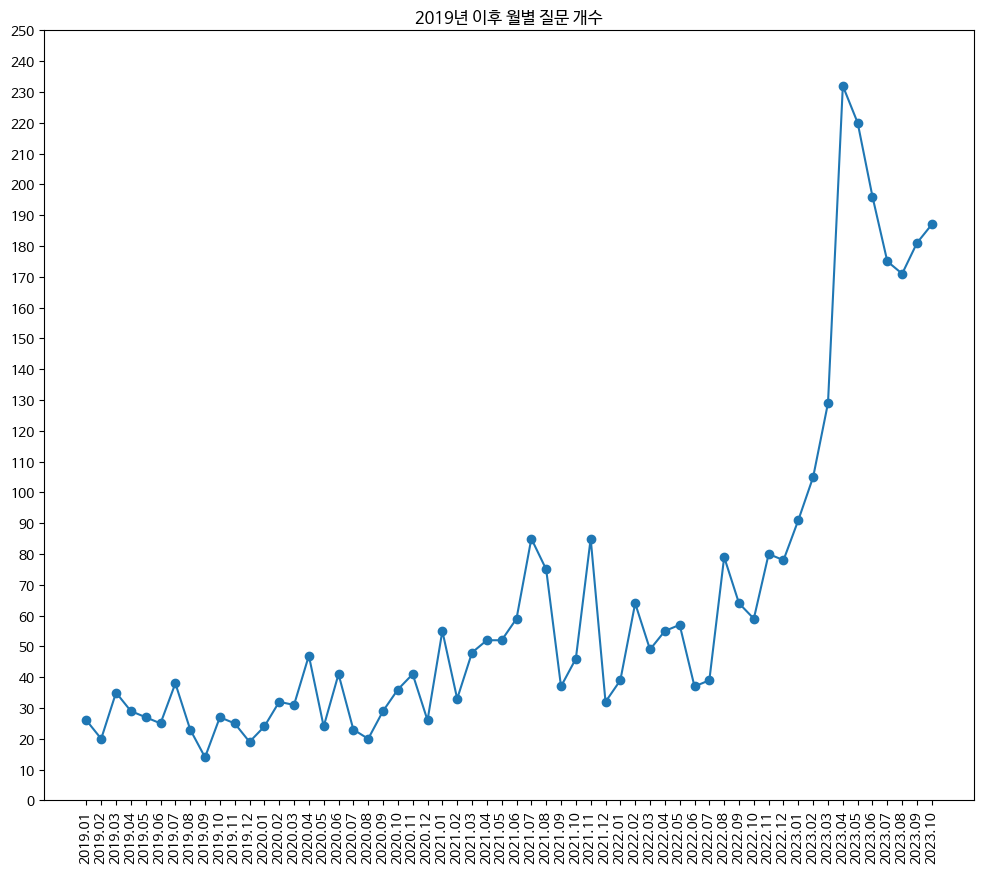

In [ ]:
# 시각화
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.figure(figsize=(12, 10))
plt.plot(q_fr.index, q_fr, marker='o')
plt.rc('font', family='NanumBarunGothic')
plt.title("2019년 이후 월별 질문 개수")
plt.xticks(rotation=90)
plt.yticks(range(0, 251, 10))
plt.show()
# plt.savefig('/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/N_question.jpeg')

## 3.2 제목에서의 년도별 단어 빈도수 분석

In [ ]:
# 띄어쓰기 교정
import keras
import tensorflow
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git --no-deps argument
from pykospacing import Spacing
spacing = Spacing()

no_content = jisik_df[jisik_df["제목"] != "전세사기 피해"]

title_2019 = no_content[no_content["작성일"].str.contains("2019")]["제목"]
title_2020 = no_content[no_content["작성일"].str.contains("2020")]["제목"]
title_2021 = no_content[no_content["작성일"].str.contains("2021")]["제목"]
title_2022 = no_content[no_content["작성일"].str.contains("2022")]["제목"]
title_2023 = no_content[no_content["작성일"].str.contains("2023")]["제목"]

annual_list = [title_2019, title_2020, title_2021, title_2022, title_2023]
for i in annual_list:
  for j in range(len(i)):
    i.iloc[j] = spacing(i.iloc[j])

<ipython-input-21-61c4cf49dbad>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i.iloc[j] = spacing(i.iloc[j])


In [ ]:
# 형태소 추출
annual_word_list = [[], [], [], [], []]
for i in range(len(annual_list)):
  word_list = annual_word_list[i]
  for j in range(len(annual_list[i])):
    tokens = kiwi.tokenize(annual_list[i].iloc[j], stopwords=stopwords)
    for k in tokens:
      if ((k.tag in use_list_n) and (len(k.form) > 1) and (k.form not in ["문의", "답변", "질문"])) or (k.form in one_syllable_list):
        word_list.append(k.form)

In [ ]:
# 고유값 및 횟수 추출
rank_2019, co_2019 = (np.unique(annual_word_list[0], return_counts=True))
rank_2020, co_2020 = (np.unique(annual_word_list[1], return_counts=True))
rank_2021, co_2021 = (np.unique(annual_word_list[2], return_counts=True))
rank_2022, co_2022 = (np.unique(annual_word_list[3], return_counts=True))
rank_2023, co_2023 = (np.unique(annual_word_list[4], return_counts=True))

In [ ]:
# 데이터프레임으로 변환 후 병합
ra_df_2019 = (pd.DataFrame({"word" : rank_2019,
              "counts" : co_2019})).sort_values(by="counts", axis=0, ascending=False).iloc[:50]

ra_df_2020 = (pd.DataFrame({"word" : rank_2020,
              "counts" : co_2020})).sort_values(by="counts", axis=0, ascending=False).iloc[:50]

ra_df_2021 = (pd.DataFrame({"word" : rank_2021,
              "counts" : co_2021})).sort_values(by="counts", axis=0, ascending=False).iloc[:50]

ra_df_2022 = (pd.DataFrame({"word" : rank_2022,
              "counts" : co_2022})).sort_values(by="counts", axis=0, ascending=False).iloc[:50]

ra_df_2023 = (pd.DataFrame({"word" : rank_2023,
              "counts" : co_2023})).sort_values(by="counts", axis=0, ascending=False).iloc[:50]

word_rank = pd.DataFrame({"2019년" : list(ra_df_2019["word"]),
                          "2020년" : list(ra_df_2020["word"]),
                          "2021년" : list(ra_df_2021["word"]),
                          "2022년" : list(ra_df_2022["word"]),
                          "2023년" : list(ra_df_2023["word"])}, index = range(50))
word_rank
# word_rank.to_excel("/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/top_50.xlsx", index=False)

,2019년,2020년,2021년,2022년,2023년
0,전세,전세,전세,전세,전세
1,대출,대출,대출,사기,사기
2,사기,사기,사기,대출,대출
3,계약,개인,계약,계약,경매
4,개인,회생,집,개인,관련
5,부동산,집,관련,집,집
6,관련,계약,부동산,관련,피해
7,회생,관련,경매,보증금,계약
8,집,소송,보험,회생,보증금
9,보증금,보증금,보증,부동산,반환


## 3.2 Ngram 분석

In [ ]:
# Trigram 만들기
trigram = []
for i in jisik_df["content word"]:
  for j in range(len(i) - 2):
    tr_list = []
    tr_list.extend([i[j], i[j+1], i[j+2]])
    trigram.append(tr_list)

trigram_arr = np.array(trigram)
tg, co = np.unique(trigram_arr, axis=0, return_counts=True)
trigram_df = pd.DataFrame(tg, columns=["키워드1", "키워드2", "키워드3"])
trigram_df["빈도"] = co

trigram_df = trigram_df.sort_values("빈도", ascending=False)
trigram_df.
# trigram_df["키워드1"] = trigram_df["키워드1"] + " " + trigram_df["키워드2"]
# (trigram_df[["키워드1", "키워드3", "빈도"]][:100]).to_excel("/content/drive/MyDrive/2023학년도 2학기/텍스트 정보분석/프로젝트/merged_trigram.xlsx", index=False)

,키워드1,키워드2,키워드3,빈도
14180,개인,회생,신청,1017
13334,개인,회생,개인,721
321482,주택,담보,대출,683
300553,전세,자금,대출,664
389566,회생,개인,회생,609
...,...,...,...,...
141777,방법,차량,개인,1
141776,방법,짜다,증거,1
141775,방법,집행,유예,1
141774,방법,집주인,집주인,1
